/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Performance Table (Train, Validation, Test):
   Neurons  Train MSE  Train RMSE  Train MAE  Train R2 Score   Val MSE  \
0       32   0.001987    0.044578   0.034186        0.881110  0.001375   
1       64   0.001726    0.041543   0.027597        0.896744  0.000960   
2      128   0.000797    0.028237   0.018451        0.952296  0.000301   
3      256   0.000878    0.029634   0.019346        0.947458  0.000404   

   Val RMSE   Val MAE  Val R2 Score  Test MSE  Test RMSE  Test MAE  \
0  0.037078  0.029348      0.872375  0.002360   0.048576  0.037467   
1  0.030987  0.023013      0.910866  0.001647   0.040584  0.027838   
2  0.017339  0.012200      0.972090  0.000975   0.031223  0.019900   
3  0.020090  0.013819      0.962534  0.000892   0.029873  0.019096   

   Test R2 Score  
0       0.828685  
1       0.880420  
2       0.929222  
3       0.935211  


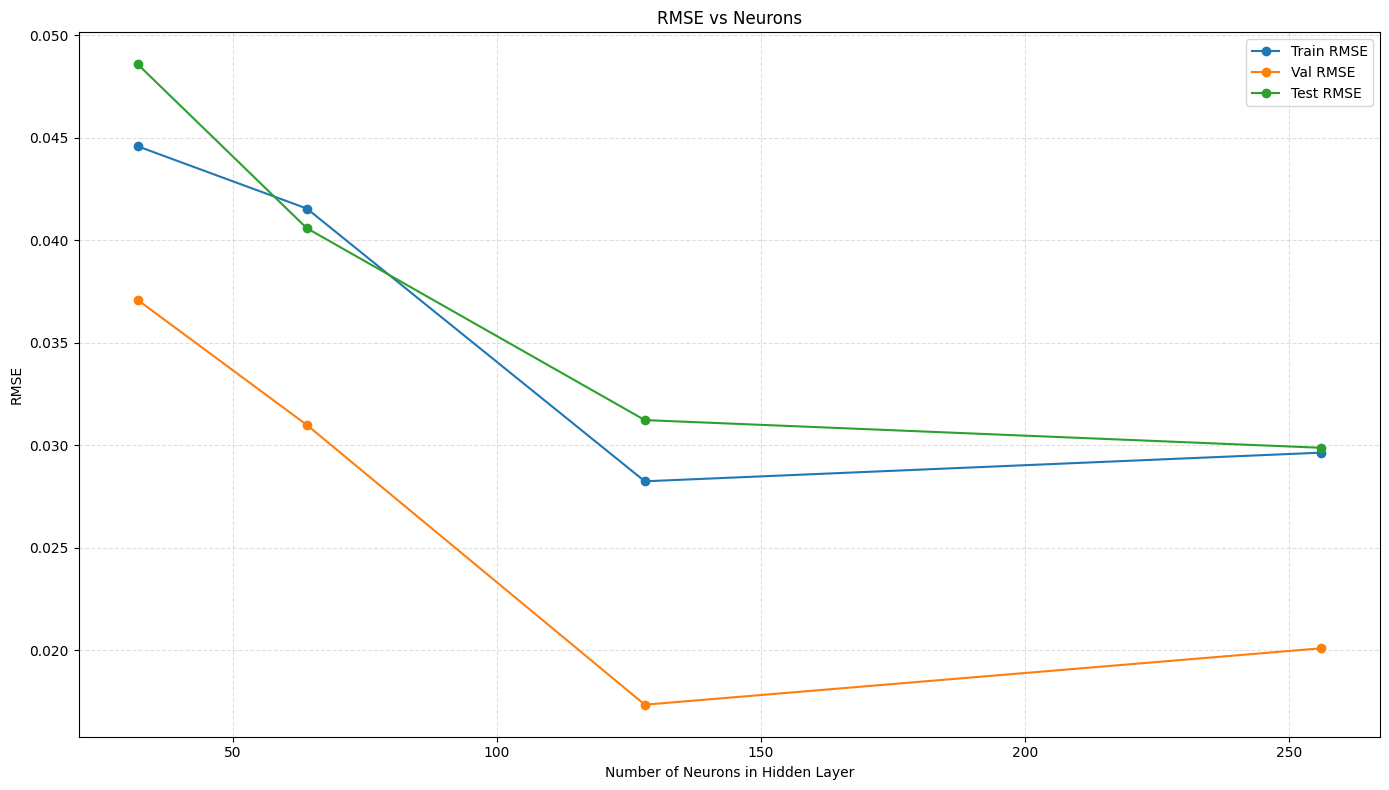

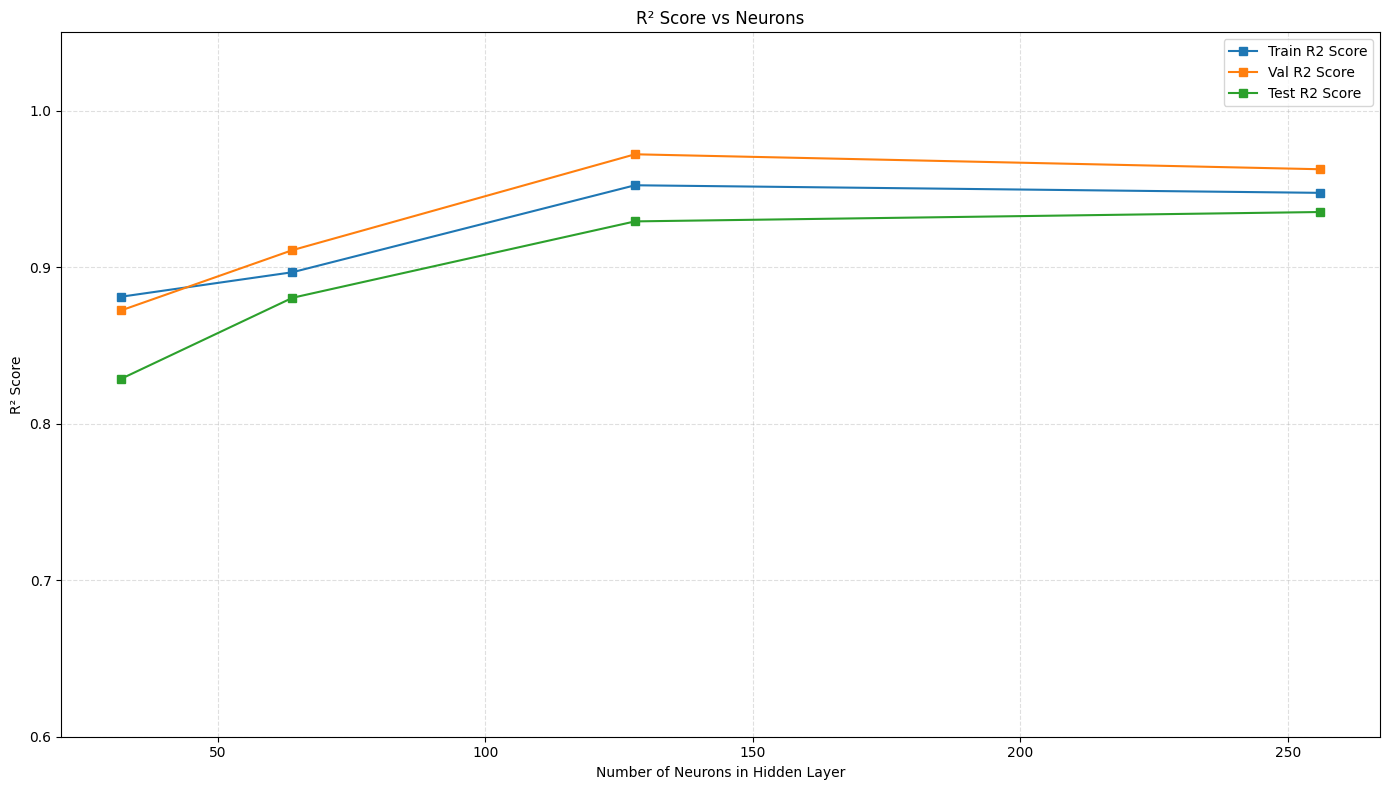

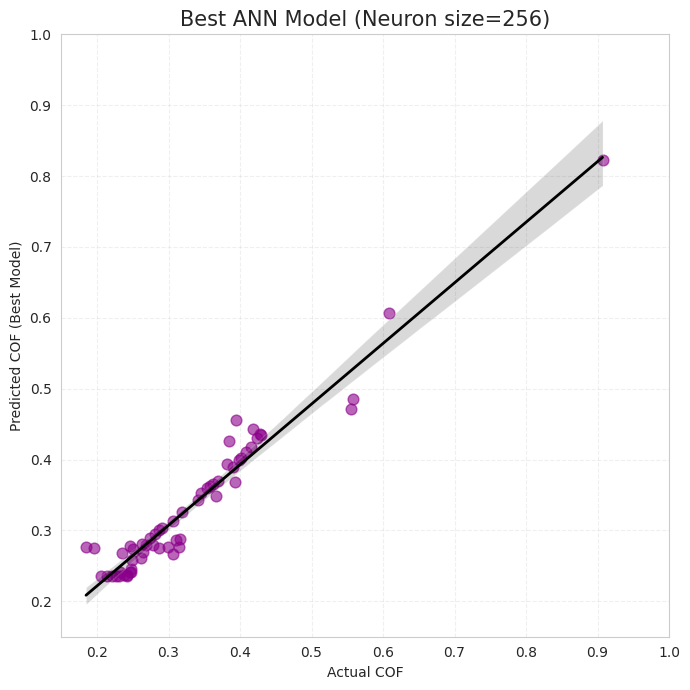

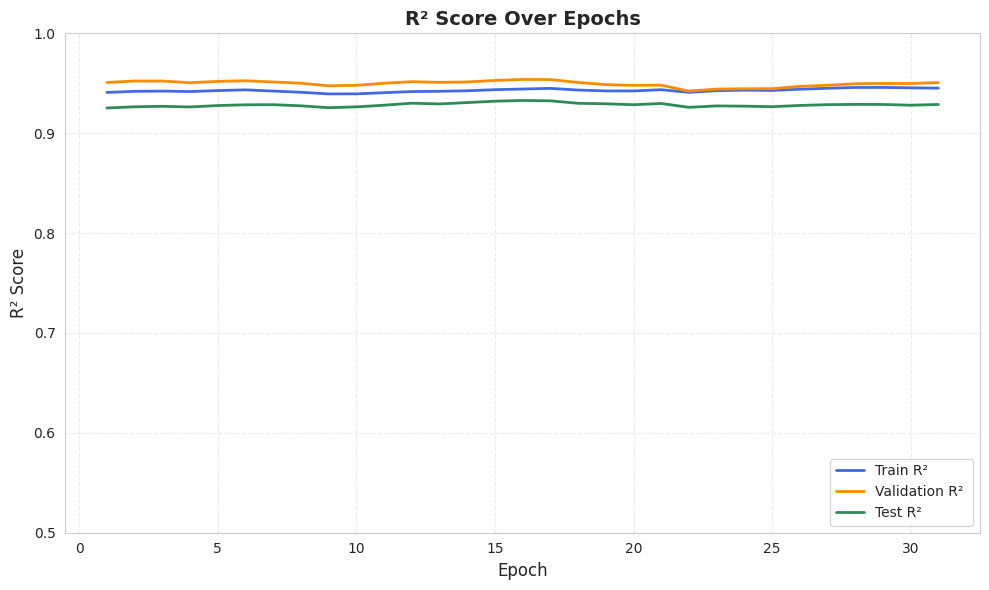

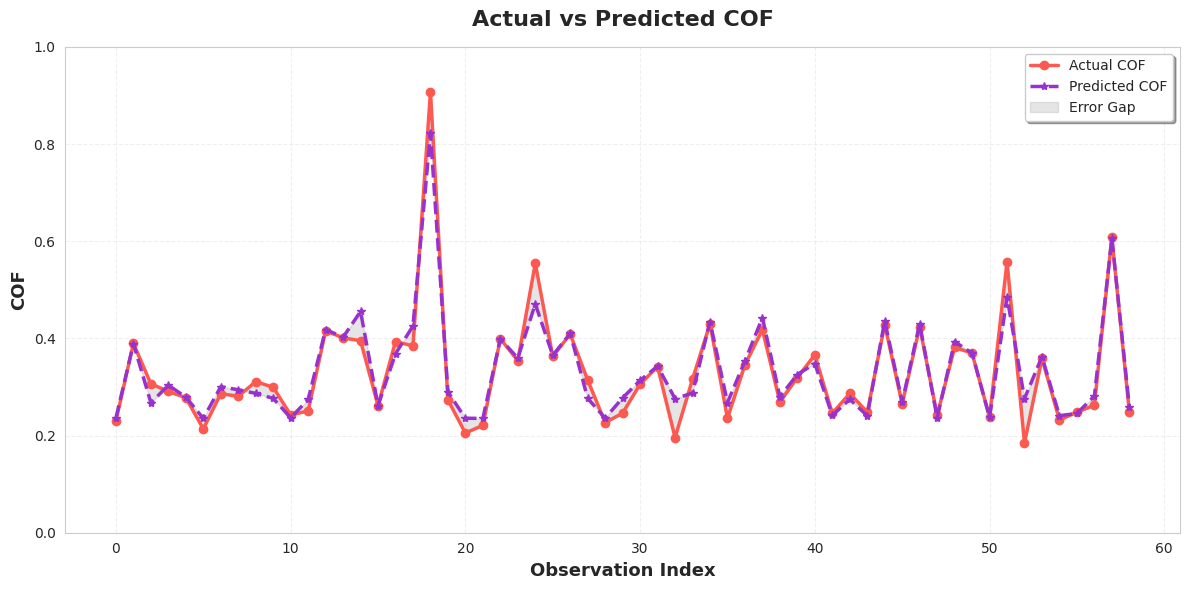

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# -------------------- Load and Preprocess Data --------------------
df = pd.read_excel('CoF.xlsx')
df.dropna(inplace=True)

# Encode categorical features
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Shuffle and split (70% train, 15% val, 15% test)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
total_len = len(df)
train_end = int(0.7 * total_len)
val_end = train_end + int(0.15 * total_len)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

# Separate features and target
X_train = train_df.drop(columns=['COF'])
y_train = train_df['COF']
X_val = val_df.drop(columns=['COF'])
y_val = val_df['COF']
X_test = test_df.drop(columns=['COF'])
y_test = test_df['COF']

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# -------------------- ANN Model Builder --------------------
def build_ann_model(input_size, hidden_layer_neurons):
    model = Sequential([
        Dense(hidden_layer_neurons, activation='relu', input_shape=(input_size,)),
        Dropout(0.3),
        Dense(max(hidden_layer_neurons // 2, 1), activation='relu'),
        Dropout(0.3),
        Dense(1)  # Output layer
    ])
    return model


# -------------------- Custom R² Tracker --------------------
class R2History(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.history = {'train': [], 'val': [], 'test': []}

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.X_train, verbose=0).flatten()
        y_val_pred = self.model.predict(self.X_val, verbose=0).flatten()
        y_test_pred = self.model.predict(self.X_test, verbose=0).flatten()

        self.history['train'].append(r2_score(self.y_train, y_train_pred))
        self.history['val'].append(r2_score(self.y_val, y_val_pred))
        self.history['test'].append(r2_score(self.y_test, y_test_pred))

# -------------------- Loop over neuron samples --------------------
neuron_samples = [32, 64, 128, 256]
results = []
best_model = None
best_rmse = float('inf')
best_y_pred = None

for neurons in neuron_samples:
    tf.keras.backend.clear_session()

    model = build_ann_model(input_size=X_train.shape[1], hidden_layer_neurons=neurons)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=16,
        callbacks=[early_stop],
        verbose=0
    )

    # Predictions
    y_pred_train = model.predict(X_train).flatten()
    y_pred_val = model.predict(X_val).flatten()
    y_pred_test = model.predict(X_test).flatten()

    # Metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    mse_val = mean_squared_error(y_val, y_pred_val)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    r2_val = r2_score(y_val, y_pred_val)

    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    results.append({
        'Neurons':  neurons,
        'Train MSE': mse_train,
        'Train RMSE': rmse_train,
        'Train MAE': mae_train,
        'Train R2 Score': r2_train,
        'Val MSE': mse_val,
        'Val RMSE': rmse_val,
        'Val MAE': mae_val,
        'Val R2 Score': r2_val,
        'Test MSE': mse_test,
        'Test RMSE': rmse_test,
        'Test MAE': mae_test,
        'Test R2 Score': r2_test
    })

    if rmse_test < best_rmse:
        best_rmse = rmse_test
        best_model = model
        best_y_pred = y_pred_test
 # Track R² for the best model
        r2_tracker = R2History(X_train, y_train, X_val, y_val, X_test, y_test)
        best_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=300,
            batch_size=16,
            callbacks=[early_stop, r2_tracker],
            verbose=0
        )
        best_r2_tracker = r2_tracker

# -------------------- Create Performance Table --------------------
results_df = pd.DataFrame(results)
print("\nPerformance Table (Train, Validation, Test):")
print(results_df)

# -------------------- RMSE Comparison --------------------
plt.figure(figsize=(14, 8))
for metric in ['Train RMSE', 'Val RMSE', 'Test RMSE']:
    plt.plot(results_df['Neurons'], results_df[metric], marker='o', label=metric)

plt.title("RMSE vs Neurons")
plt.xlabel("Number of Neurons in Hidden Layer")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# -------------------- R² Score Comparison --------------------
plt.figure(figsize=(14, 8))
for metric in ['Train R2 Score', 'Val R2 Score', 'Test R2 Score']:
    plt.plot(results_df['Neurons'], results_df[metric], marker='s', label=metric)

plt.title("R² Score vs Neurons")
plt.xlabel("Number of Neurons in Hidden Layer")
plt.ylabel("R² Score")
plt.ylim(0.6, 1.05)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# -------------------- Regression Plot: Best Model --------------------
sns.set_style("whitegrid")
plt.figure(figsize=(7, 7))
sns.regplot(
    x=y_test,
    y=best_y_pred,
    scatter_kws={'alpha': 0.6, 's': 60, 'color': '#8B008B'},
    line_kws={'color': 'black', 'lw': 2}
)
plt.xlabel("Actual COF")
plt.ylabel("Predicted COF (Best Model)")
plt.title(f"Best ANN Model (Neuron size={results_df.loc[results_df['Test RMSE'].idxmin(), 'Neurons']})", fontsize=15)
plt.xlim(0.15, 1)
plt.ylim(0.15, 1)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- R² Smoothing Function --------------------
def smooth_curve(points, factor=0.9):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

# Smooth the R² score histories
train_r2_smooth = smooth_curve(best_r2_tracker.history['train'])
val_r2_smooth = smooth_curve(best_r2_tracker.history['val'])
test_r2_smooth = smooth_curve(best_r2_tracker.history['test'])

# -------------------- Final R² Score Plot --------------------
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_r2_smooth) + 1)

plt.plot(epochs, train_r2_smooth, label='Train R² ', color='royalblue', linewidth=2)
plt.plot(epochs, val_r2_smooth, label='Validation R² ', color='darkorange', linewidth=2)
plt.plot(epochs, test_r2_smooth, label='Test R² ', color='seagreen', linewidth=2)

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.title("R² Score Over Epochs", fontsize=14, weight='bold')
plt.ylim(0.5, 1)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
# -------------------- Line Plot: Actual vs Predicted --------------------
plt.figure(figsize=(12, 6))
obs_index = np.arange(len(y_test))

plt.plot(
    obs_index, y_test.values,
    label="Actual COF",
    marker='o', markersize=6, linewidth=2.5,
    color='#FC5A50'
)

plt.plot(
    obs_index, best_y_pred,
    label="Predicted COF",
    marker='*', markersize=6, linestyle='--', linewidth=2.5,
    color='#9932CC'
)

plt.fill_between(
    obs_index, y_test.values, best_y_pred,
    color='gray', alpha=0.2, label="Error Gap"
)

plt.xlabel("Observation Index", fontsize=13, weight='bold')
plt.ylabel("COF", fontsize=13, weight='bold')
plt.title("Actual vs Predicted COF", fontsize=16, weight='bold', pad=15)
plt.ylim(0, 1)
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Performance Table (Train, Validation, Test):
   Neurons  Train MSE  Train RMSE  Train MAE  Train R2 Score   Val MSE  \
0       32   0.000044    0.006669   0.005417        0.721340  0.000042   
1       64   0.000022    0.004730   0.003857        0.859871  0.000021   
2      128   0.000016    0.003959   0.003268        0.901810  0.000014   
3      256   0.000011    0.003313   0.002511        0.931234  0.000009   

   Val RMSE   Val MAE  Val R2 Score  Test MSE  Test RMSE  Test MAE  \
0  0.006512  0.005187      0.725911  0.000037   0.006112  0.004904   
1  0.004576  0.003715      0.864616  0.000022   0.004647  0.003589   
2  0.003696  0.002816      0.911698  0.000015   0.003877  0.003173   
3  0.003055  0.002202      0.939673  0.000011   0.003244  0.002510   

   Test R2 Score  
0       0.765741  
1       0.864589  
2       0.905720  
3       0.933998  


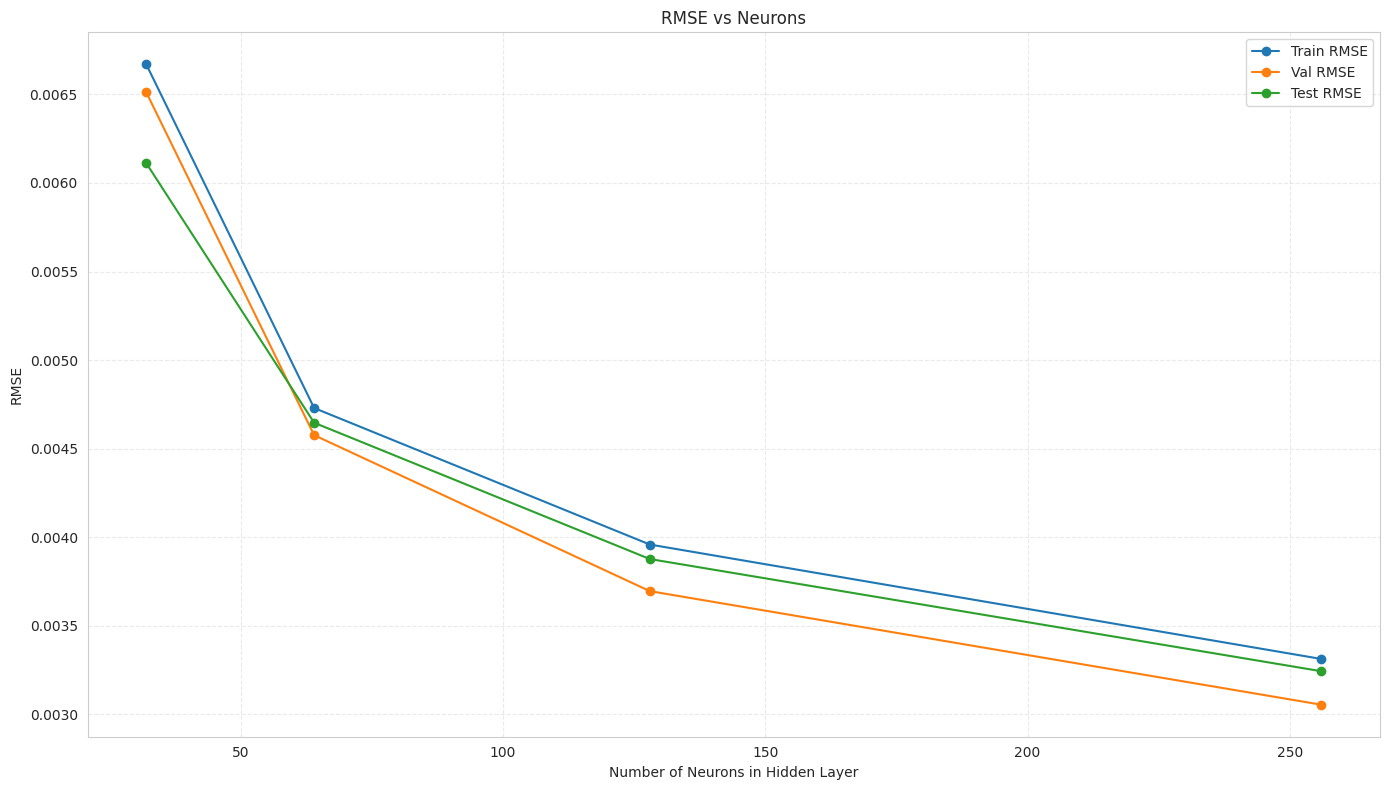

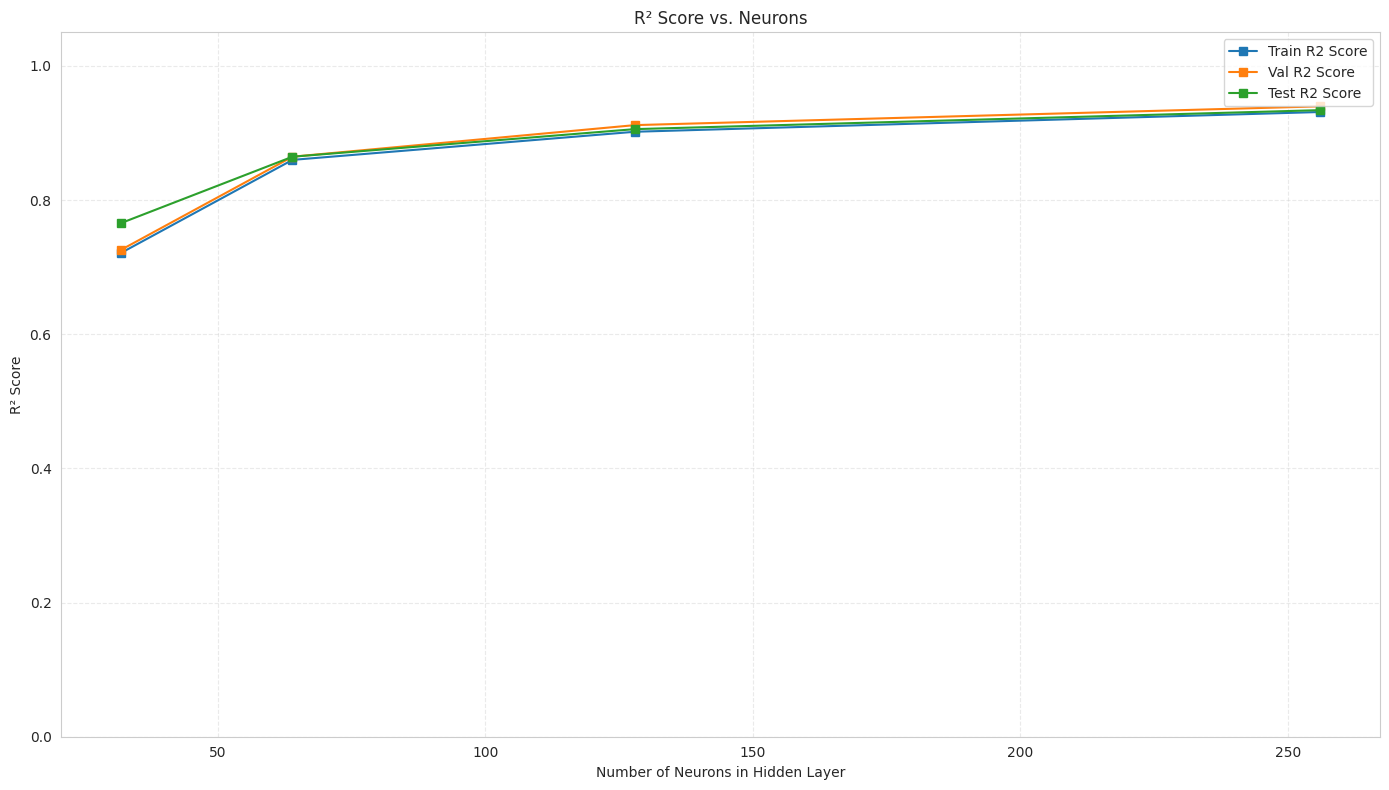

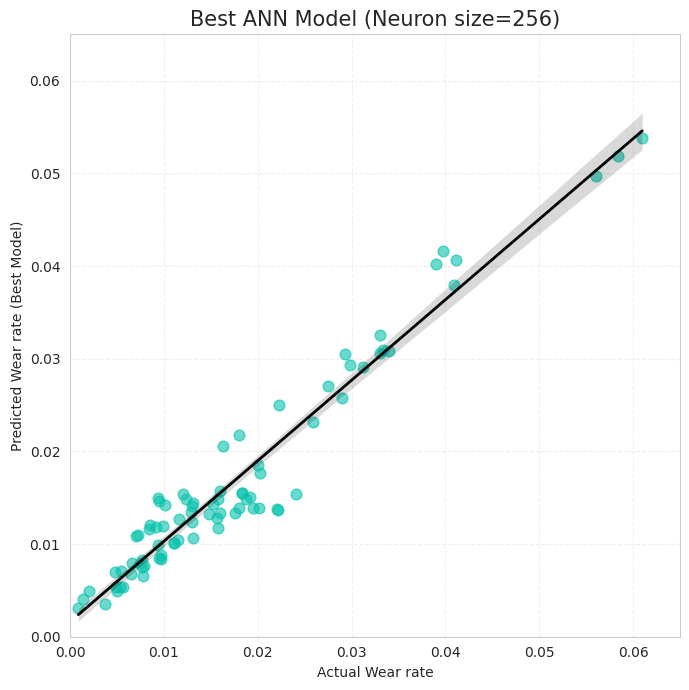

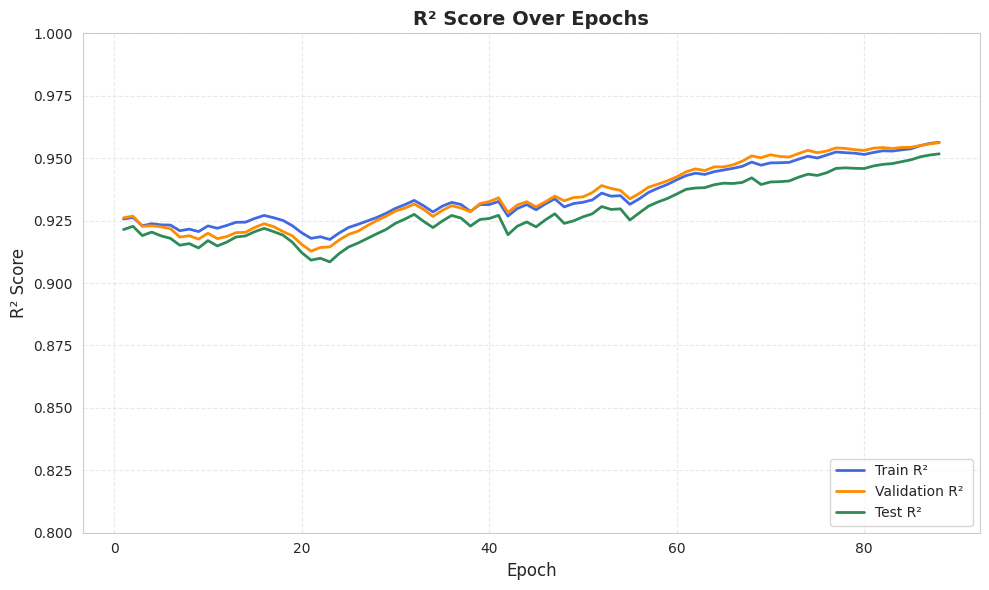

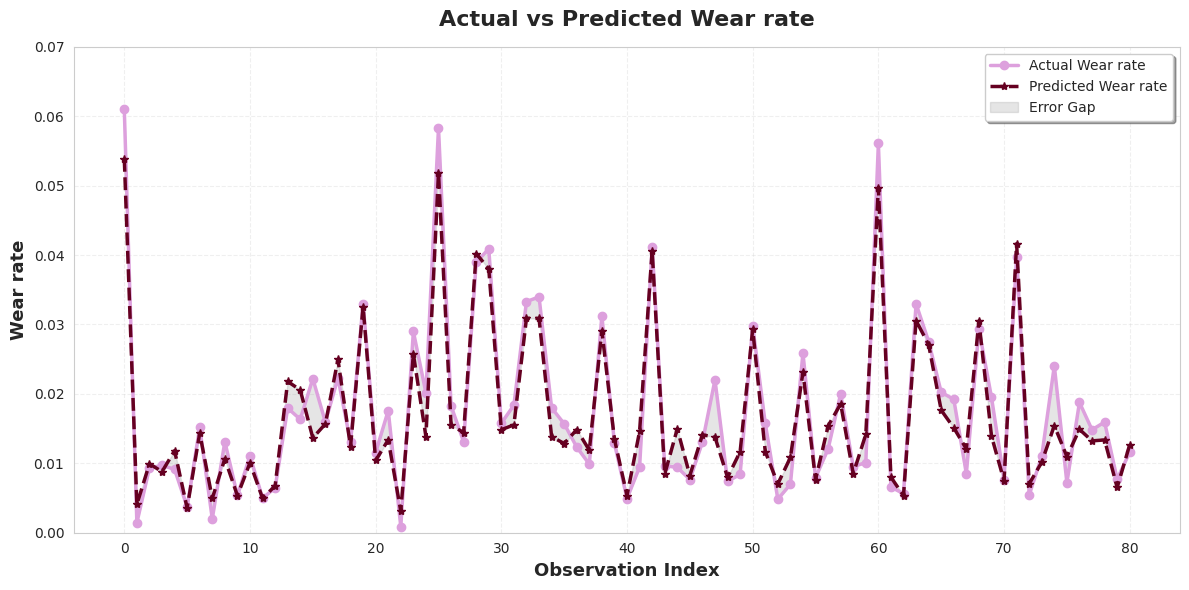

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# -------------------- Load and Preprocess Data --------------------
df = pd.read_excel('Wear_rate.xlsx')
df.dropna(inplace=True)

# Encode categorical features
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Shuffle and split (70% train, 15% val, 15% test)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
total_len = len(df)
train_end = int(0.7 * total_len)
val_end = train_end + int(0.15 * total_len)
train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

# Separate features and target
X_train = train_df.drop(columns=['Wear rate (mm3/m)'])
y_train = train_df['Wear rate (mm3/m)']
X_val = val_df.drop(columns=['Wear rate (mm3/m)'])
y_val = val_df['Wear rate (mm3/m)']
X_test = test_df.drop(columns=['Wear rate (mm3/m)'])
y_test = test_df['Wear rate (mm3/m)']

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
# -------------------- ANN Model Builder --------------------
def build_ann_model(input_size, hidden_layer_neurons):
    model = Sequential([
        Dense(hidden_layer_neurons, activation='relu', input_shape=(input_size,)),
        Dropout(0.3),
        Dense(max(hidden_layer_neurons // 2, 1), activation='relu'),
        Dropout(0.3),
        Dense(1)  # Output layer
    ])
    return model


# -------------------- Custom R² Tracker --------------------
class R2History(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.history = {'train': [], 'val': [], 'test': []}

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.X_train, verbose=0).flatten()
        y_val_pred = self.model.predict(self.X_val, verbose=0).flatten()
        y_test_pred = self.model.predict(self.X_test, verbose=0).flatten()

        self.history['train'].append(r2_score(self.y_train, y_train_pred))
        self.history['val'].append(r2_score(self.y_val, y_val_pred))
        self.history['test'].append(r2_score(self.y_test, y_test_pred))

# -------------------- Loop over neuron samples --------------------
neuron_samples = [32, 64, 128, 256]
results = []
best_model = None
best_rmse = float('inf')
best_y_pred = None

for neurons in neuron_samples:
    tf.keras.backend.clear_session()

    model = build_ann_model(input_size=X_train.shape[1], hidden_layer_neurons=neurons)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=16,
        callbacks=[early_stop],
        verbose=0
    )

    # Predictions
    y_pred_train = model.predict(X_train).flatten()
    y_pred_val = model.predict(X_val).flatten()
    y_pred_test = model.predict(X_test).flatten()

    # Metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    mse_val = mean_squared_error(y_val, y_pred_val)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    r2_val = r2_score(y_val, y_pred_val)

    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    results.append({
        'Neurons':  neurons,
        'Train MSE': mse_train,
        'Train RMSE': rmse_train,
        'Train MAE': mae_train,
        'Train R2 Score': r2_train,
        'Val MSE': mse_val,
        'Val RMSE': rmse_val,
        'Val MAE': mae_val,
        'Val R2 Score': r2_val,
        'Test MSE': mse_test,
        'Test RMSE': rmse_test,
        'Test MAE': mae_test,
        'Test R2 Score': r2_test
    })

    if rmse_test < best_rmse:
        best_rmse = rmse_test
        best_model = model
        best_y_pred = y_pred_test
 # Track R² for the best model
        r2_tracker = R2History(X_train, y_train, X_val, y_val, X_test, y_test)
        best_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=300,
            batch_size=16,
            callbacks=[early_stop, r2_tracker],
            verbose=0
        )
        best_r2_tracker = r2_tracker

# -------------------- Create Performance Table --------------------
results_df = pd.DataFrame(results)
print("\nPerformance Table (Train, Validation, Test):")
print(results_df)

# -------------------- RMSE Comparison --------------------
plt.figure(figsize=(14, 8))
for metric in ['Train RMSE', 'Val RMSE', 'Test RMSE']:
    plt.plot(results_df['Neurons'], results_df[metric], marker='o', label=metric)

plt.title("RMSE vs Neurons")
plt.xlabel("Number of Neurons in Hidden Layer")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# -------------------- R² Score Comparison --------------------
plt.figure(figsize=(14, 8))
for metric in ['Train R2 Score', 'Val R2 Score', 'Test R2 Score']:
    plt.plot(results_df['Neurons'], results_df[metric], marker='s', label=metric)

plt.title("R² Score vs. Neurons")
plt.xlabel("Number of Neurons in Hidden Layer")
plt.ylabel("R² Score")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# -------------------- Regression Plot: Best Model --------------------
sns.set_style("whitegrid")
plt.figure(figsize=(7, 7))
sns.regplot(
    x=y_test,
    y=best_y_pred,
    scatter_kws={'alpha': 0.6, 's': 60, 'color': '#06C2AC'},
    line_kws={'color': 'black', 'lw': 2}
)
plt.xlabel("Actual Wear rate")
plt.ylabel("Predicted Wear rate (Best Model)")
plt.title(f"Best ANN Model (Neuron size={results_df.loc[results_df['Test RMSE'].idxmin(), 'Neurons']})", fontsize=15)
plt.xlim(0, 0.065)
plt.ylim(0, 0.065)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- R² Smoothing Function --------------------
def smooth_curve(points, factor=0.9):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

# Smooth the R² score histories
train_r2_smooth = smooth_curve(best_r2_tracker.history['train'])
val_r2_smooth = smooth_curve(best_r2_tracker.history['val'])
test_r2_smooth = smooth_curve(best_r2_tracker.history['test'])

# -------------------- Final R² Score Plot --------------------
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_r2_smooth) + 1)

plt.plot(epochs, train_r2_smooth, label='Train R² ', color='royalblue', linewidth=2)
plt.plot(epochs, val_r2_smooth, label='Validation R² ', color='darkorange', linewidth=2)
plt.plot(epochs, test_r2_smooth, label='Test R² ', color='seagreen', linewidth=2)

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.title("R² Score Over Epochs", fontsize=14, weight='bold')
plt.ylim(0.8, 1)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
# -------------------- Line Plot: Actual vs Predicted --------------------
plt.figure(figsize=(12, 6))
obs_index = np.arange(len(y_test))

plt.plot(
    obs_index, y_test.values,
    label="Actual Wear rate",
    marker='o', markersize=6, linewidth=2.5,
    color='#DDA0DD'
)

plt.plot(
    obs_index, best_y_pred,
    label="Predicted Wear rate",
    marker='*', markersize=6, linestyle='--', linewidth=2.5,
    color='#650021'
)

plt.fill_between(
    obs_index, y_test.values, best_y_pred,
    color='gray', alpha=0.2, label="Error Gap"
)

plt.xlabel("Observation Index", fontsize=13, weight='bold')
plt.ylabel("Wear rate", fontsize=13, weight='bold')
plt.title("Actual vs Predicted Wear rate", fontsize=16, weight='bold', pad=15)
plt.ylim(0, 0.07)
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
